[0.2443609  0.23941295]
[4.7556391  5.04278569]
runtime of FedRelax  1.6535687446594238
average train error : 0.023246574219130615
average val error : 0.6651834177251852


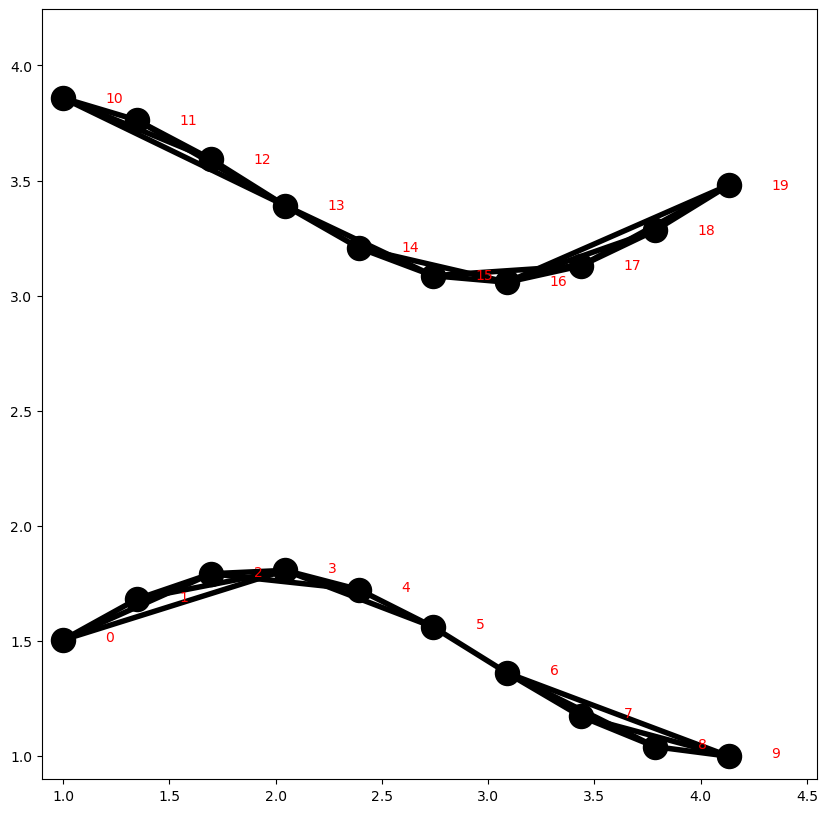

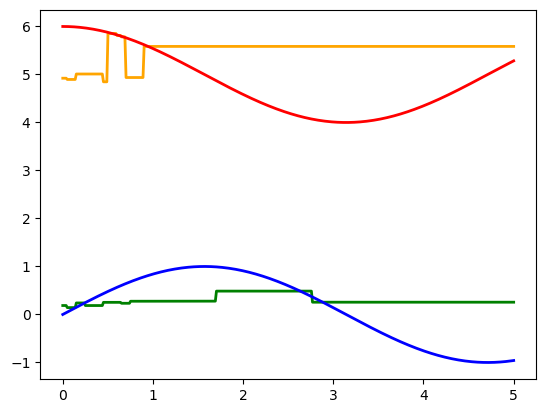

In [2]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import networkx as nx 
import pickle
from sklearn.neighbors import kneighbors_graph
from numpy import linalg as LA
import time
from sklearn.metrics import mean_squared_error

# load graph object from file
G = pickle.load(open('QuizGraphLearning.pickle', 'rb'))

for iter_node in G.nodes(): 
    nodefeatures = np.array([np.mean(G.nodes[iter_node]["Xtrain"]),np.mean(G.nodes[iter_node]["ytrain"])])
    G.nodes[iter_node]['coords'] = nodefeatures 
    G.nodes[iter_node]["name"] = str(iter_node)

print(G.nodes[0]['coords'])


def PlotGraph(graphin,pos='coord',annotate="name"): 
    
    # the numpy array x will hold the horizontal coord of markers for each node in emp. graph graphin
    x = np.zeros(len(graphin.nodes))
    # vertical coords of markers 
    y = np.zeros(len(graphin.nodes))
    
    for iter_node in graphin.nodes:
        x[iter_node]= graphin.nodes[iter_node][pos][0] 
        y[iter_node]= graphin.nodes[iter_node][pos][1]

    # standareize the coordinates of node markers 
    x = (x - np.min(x, axis=0))/np.std(x, axis=0) + 1 
    y = (y - np.min(y, axis=0))/np.std(y, axis=0) + 1 

    # create a figure with prescribed dimensions 
    fig, ax = plt.subplots(figsize=(10,10))
    
    # generate a scatter plot with each marker representing a node in graphin
    ax.scatter(x, y, 300, marker='o', color='Black')
    
    # draw links between two nodes if they are connected by an edge 
    # in the empirical graph. use the "weight" of the edge to determine the line thickness
    for edge_dmy in graphin.edges:
        ax.plot([x[edge_dmy[0]],x[edge_dmy[1]]],[y[edge_dmy[0]],y[edge_dmy[1]]],c='black',lw=4*graphin.edges[edge_dmy]["weight"])

    # annotate each marker by the node attribute whose name is stored in the input parameter "annotate"
    for iter_node in graphin.nodes : 
        ax.annotate(str(graphin.nodes[iter_node][annotate]),(x[iter_node]+0.2, 0.995*y[iter_node]),c="red" )
    ax.set_ylim(0.9*np.min(y),1.1*np.max(y))
    ax.set_xlim(0.9*np.min(x),1.1*np.max(x))    
    

def AddEdges(graphin,nrneighbors=3,pos='coord',refdistance=1): 
    edges = graphin.edges()
    graphin.remove_edges_from(edges)
    
    # build up a numpy array tmp_data which has one row for each node in graphin
    tmp_data = np.zeros((len(graphin.nodes()),len(graphin.nodes[0][pos])))
    for iter_node in graphin.nodes(): 
        # each row of tmp_data holds the numpy array stored in the node attribute selected by parameter "pos" 
        tmp_data[iter_node,:] = graphin.nodes[iter_node][pos]
        
    A = kneighbors_graph(tmp_data, nrneighbors, mode='connectivity', include_self=False)
    A.toarray()
    for iter_i in range(len(graphin.nodes)): 
        for iter_j in range(len(graphin.nodes)): 
            # add an edge between nodes i,j if entry A_i,j is non-zero 
            if A[iter_i,iter_j] > 0 : 
                graphin.add_edge(iter_i, iter_j)
                # use the Euclidean distance between node attribute selected by parameter "pos" 
                # to compute the edge weight 
                graphin.edges[(iter_i,iter_j)]["weight"] = np.exp(-LA.norm(tmp_data[iter_i,:]-tmp_data[iter_j,:],2)/refdistance)
                
                
def FedRelax(G, Xtest, regparam=0, maxiter=100):
    # Determine the number of data points in the test set
    testsize = Xtest.shape[0]
    
    # Attach a DecisionTreeRegressor as the local model to each node in G
    for node_i in G.nodes(data=False): 
        G.nodes[node_i]["model"] = DecisionTreeRegressor(max_depth=4).fit(G.nodes[node_i]["Xtrain"], G.nodes[node_i]["ytrain"])
        G.nodes[node_i]["sample_weight"] = np.ones((len(G.nodes[node_i]["ytrain"]), 1))  # Initialize sample weights
    
    # Repeat the local updates (simultaneously at all nodes) for maxiter iterations
    for iter_GD in range(maxiter):
        # Iterate over all nodes in the graph
        for node_i in G.nodes(data=False):
            # Share predictions with neighbors
            for node_j in G[node_i]:
                # Add the predictions of the current hypothesis at node j as labels
                neighbourpred = G.nodes[node_j]["model"].predict(Xtest).reshape(-1, 1)
                G.nodes[node_i]["ytrain"] = np.vstack((G.nodes[node_i]["ytrain"], neighbourpred))
                
                # Augment local dataset at node i by a new dataset obtained from the features of the test set
                G.nodes[node_i]["Xtrain"] = np.vstack((G.nodes[node_i]["Xtrain"], Xtest))
                
                # Set sample weights of added local dataset according to edge weight of edge i <-> j
                # and GTV regularization parameter
                sampleweightaug = (regparam * len(G.nodes[node_i]["ytrain"]) / testsize)
                G.nodes[node_i]["sample_weight"] = np.vstack((G.nodes[node_i]["sample_weight"], sampleweightaug * G.edges[(node_i, node_j)]["weight"] * np.ones((len(neighbourpred), 1))))
            
            # Fit the local model with the augmented dataset and sample weights
            G.nodes[node_i]["model"].fit(G.nodes[node_i]["Xtrain"], G.nodes[node_i]["ytrain"], sample_weight=G.nodes[node_i]["sample_weight"].reshape(-1))

AddEdges(G,nrneighbors=3,pos='coords',refdistance=100)

print(G.nodes[iter_node]['coords'])

PlotGraph(G,pos='coords',annotate='name')

# generate global test_set
X_test = np.arange(0.0, 1, 0.1)[:, np.newaxis]
# get the start time
st = time.time()
FedRelax(G,X_test,0.1,100)
end = time.time()
print("runtime of FedRelax ",end-st)

# compute node-wise train and val errors 

for iter_node in G.nodes(): 
    trainedlocalmodel = G.nodes[iter_node]["model"]
    trainfeatures = G.nodes[iter_node]["Xtrain"]
    trainlabels=G.nodes[iter_node]["ytrain"]
    G.nodes[iter_node]["trainerr"] = mean_squared_error(trainlabels,trainedlocalmodel.predict(trainfeatures))
    valfeatures = G.nodes[iter_node]["Xval"]
    vallabels=G.nodes[iter_node]["yval"]
    G.nodes[iter_node]["valerr"] = mean_squared_error(vallabels,trainedlocalmodel.predict(valfeatures))
    
   
print("average train error :",sum(nx.get_node_attributes(G, "trainerr").values())/len(G.nodes()))
print("average val error :",sum(nx.get_node_attributes(G, "valerr").values())/len(G.nodes()))

X_val = G.nodes[0]["Xval"]
y_1 = G.nodes[11]["model"].predict(X_val)
y_2 = G.nodes[5]["model"].predict(X_val)
# Plot the results
plt.figure()
plt.plot(X_val, y_1, color="orange", label="validation data cluster 0", linewidth=2)
plt.plot(X_val, y_2, color="green", label="validation data cluster 0", linewidth=2)
plt.plot(G.nodes[7]["Xval"], G.nodes[0]["yval"], color="blue", label="validation data cluster 0", linewidth=2)
plt.plot(G.nodes[15]["Xval"], G.nodes[11]["yval"], color="red", label="val data second cluster", linewidth=2)